# Week 11 Analyzing Particles in a Matrix

## Let's take a look at your homework and analyze the second image: 'Carbon fiber in Al matrix.jpg'

In the lesson you have an image with **two** different particles to analyze.    
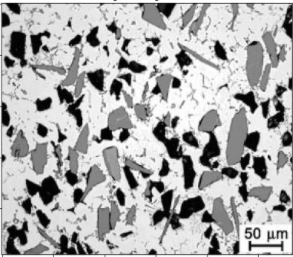  
  
In your homework you only have **one** particle type.    
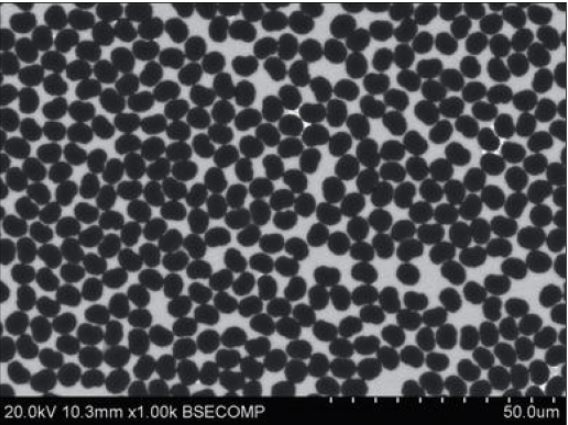  
  

### Let's adapt the code in the lesson to handle the single particle type of your homework

#### Function Definitions

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import io, color, measure
import pandas as pd
import copy
from PIL import Image
from IPython.display import display

from pathlib import Path

# prep_image takes our original Blue-Green-Red image, converts it to Red-Green-Blue, applies the pyramid filter, converts to
# grayscale, applies a gaussian blur, plots the images for us and
# and returns 4 data sets:  
#  (1) the image in RGB format
#  (2) the image filtered with pyramid filter
#  (3) the grayscale image after pyramid filtering
#  (4) the gaussian blured image in grayscale

def prep_image(BGR_image, pyr_size, pyr_range, blur_size):
    img_RGB=cv.cvtColor(BGR_image,cv.COLOR_BGR2RGB)
    img_shift=cv.pyrMeanShiftFiltering(img_RGB, pyr_size, pyr_range)  #acts on original image
    gray=cv.cvtColor(img_shift,cv.COLOR_BGR2GRAY) #move img to gray scale
    blur=cv.GaussianBlur(gray,(blur_size,blur_size),0) # acts on gray scale image
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(18, 8))
    ax1.imshow(imgfull)
    ax2.imshow(gray, cmap='gray')
    ax3.imshow(blur, cmap='gray')
    ax1.set_title('Original Image (RGB)')
    ax2.set_title('+ Pyramid Mean Shift Filter (GrayScale)')
    ax3.set_title('Gaussian Blur (GrayScale)')
    plt.tight_layout()
    return(img_RGB, img_shift, gray, blur)


# thresh_simple takes a grayscale image, applies a simple threshold with min, max variables, and 
# removes noise with the opening filter
# plots the original image along with the thresholded image
# and returns 1 data set:  
#  (1) a thresholded grayscale image containing only black (0) and white (255) pixels

def thresh_simple(image_gray, min, max, kernel_size, open_iterations):
    ret, thresh = cv.threshold(image_gray,min,max,cv.THRESH_BINARY_INV)
    kernel=cv.getStructuringElement(cv.MORPH_CROSS,(kernel_size,kernel_size))
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=open_iterations)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14, 27))
    ax1.imshow(image_gray, cmap='gray')
    ax2.imshow(opening, cmap='gray')
    ax1.set_title('Grayscale Image')
    ax2.set_title('Threshold Image (B&W)')
    plt.tight_layout()
    return(opening)

# segment takes our original Red-Green-Blue image and our thresholded image (grayscale), and applies 
# a dilation to find the sure background; an erosion to find the sure foreground, and subtracts these to find the unknown
# it then applies the watershed algorithm and marks all foreground regions with an integer value
# Plotted:  the original RGB image and the color coded semented image
# and returns 6 data sets:  
#  (1) the original image in RGB format
#  (2) the sure background image
#  (3) the sure foreground image
#  (4) the unknown region image
#  (5) the array of markers for each feature
#  (6) the color coded image

def segment(imgRGB,thresh_img, kernel_size, dilate_iter, erode_iter):
    img_RGB=copy.copy(imgRGB)
    kernel=cv.getStructuringElement(cv.MORPH_CROSS,(kernel_size,kernel_size))
    sure_bg = cv.dilate(thresh_img,kernel,iterations = dilate_iter)
    sure_fg = cv.erode(thresh_img,kernel,iterations = erode_iter)
    unknown = cv.subtract(sure_bg,sure_fg)
    ret, markers = cv.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv.watershed(img_RGB,markers) 
    img_RGB[markers ==-1] = [255,0,0]
    img2=color.label2rgb(markers, image=img_RGB, bg_label=1, alpha=0.35)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18, 8))
    ax1.imshow(imgRGB)
    ax2.imshow(img2, aspect='equal');
    ax1.set_title('marked')
    ax2.set_title('colored')
    plt.tight_layout()
    return(img_RGB, sure_bg, sure_fg, unknown, markers, img2)


#### Read in our image ('Carbon fiber in Al matrix.jpg') and prep it for thresholding

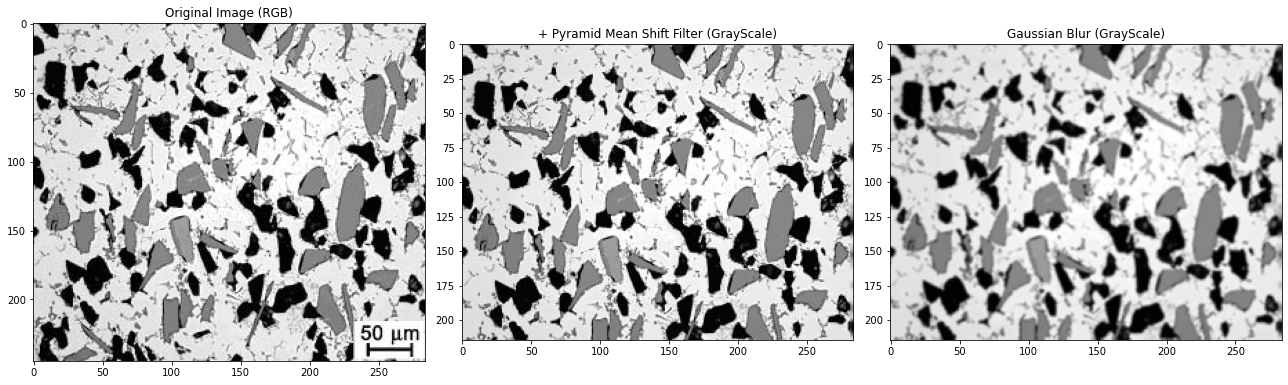

In [72]:
imgfull=cv.imread('../../images/metal matrix composite.jpg')  # cv.imread reads the image in Blue-Green-Red format
BGR_img=imgfull[0:215, :]  # I already found where to slice the image to remove the micron bar

# remember to identify your 4 variables here for the 4 returned values for this function
# I'm calling them:  img, img_shift, img_gray and img_blur
img, img_shift, img_gray, img_blur=prep_image(BGR_img, 5, 11, 3) # image (BGR), pyr size, pyr range, blur size

#the output is shown below.  Adjust the pyr size, pyr range, and blur size to see how it affects the final image

In this problem, we have two different gray levels to threshold so it might help to know where these values lie.  Let's use a histogram to see this.  

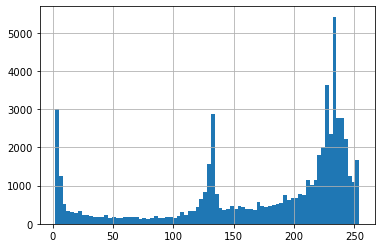

In [5]:
pd.Series(img_blur.flatten()).hist(bins=80);  # this is a histogram of gray levels
# 0 is black, 125 looks like our gray phase, 255 is pure white

#### Threshold our image twice

(1) The strategy here is to turn everything below 200 to white and above 200 to black.  This will capture both our gray and black phases.  
(2) Then do this again for a value of 100 which will capture only the black regions.  
(3) By subtracting (2) from (1) we will get only the gray regions.  

We can then analyze the black thresholded image and the gray thresholded image separately to look at each phase

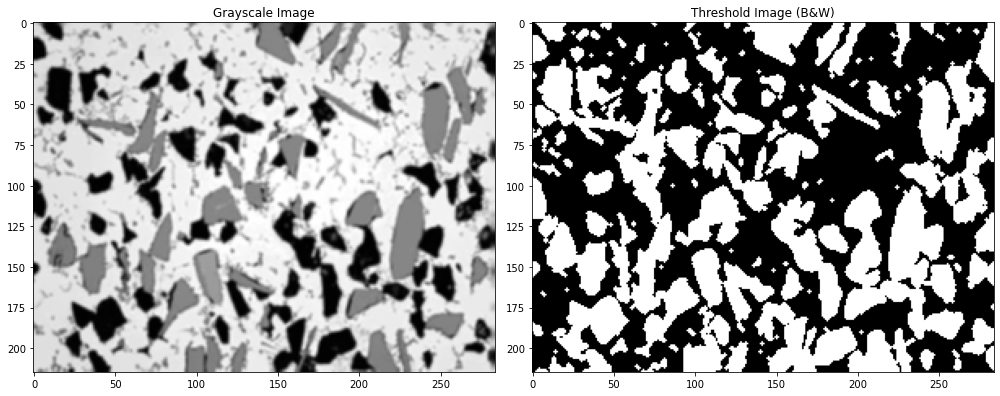

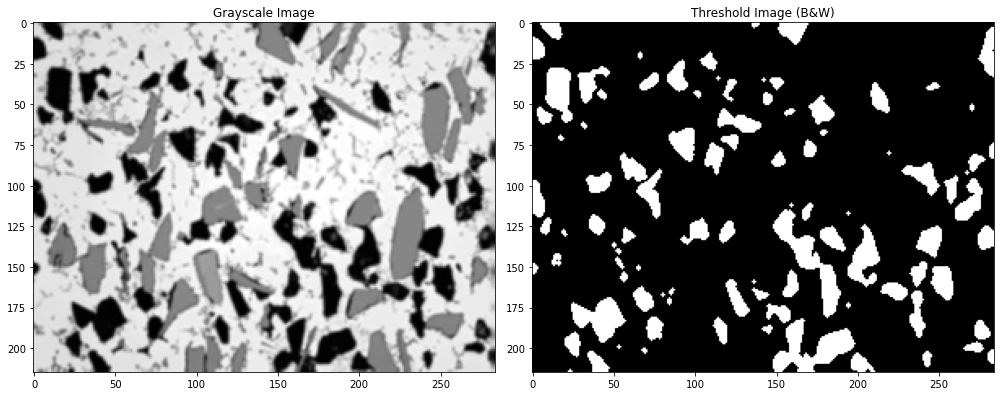

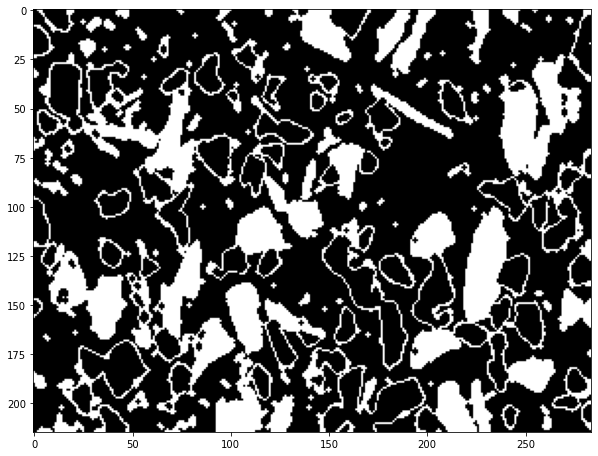

In [10]:
#see the definition for thresh_simple above for an explanation of the values 3 and 1 used below

thresh_blur1=thresh_simple(img_blur, 200, 255, 3, 1) #everything below 200 is set to white

thresh_blur2=thresh_simple(img_blur, 100, 255, 3, 1) #everything below 100 is set to white

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
thresh=thresh_blur1-thresh_blur2 #this gives only the gray regions as white
ax.imshow(thresh, cmap='gray')
plt.show()

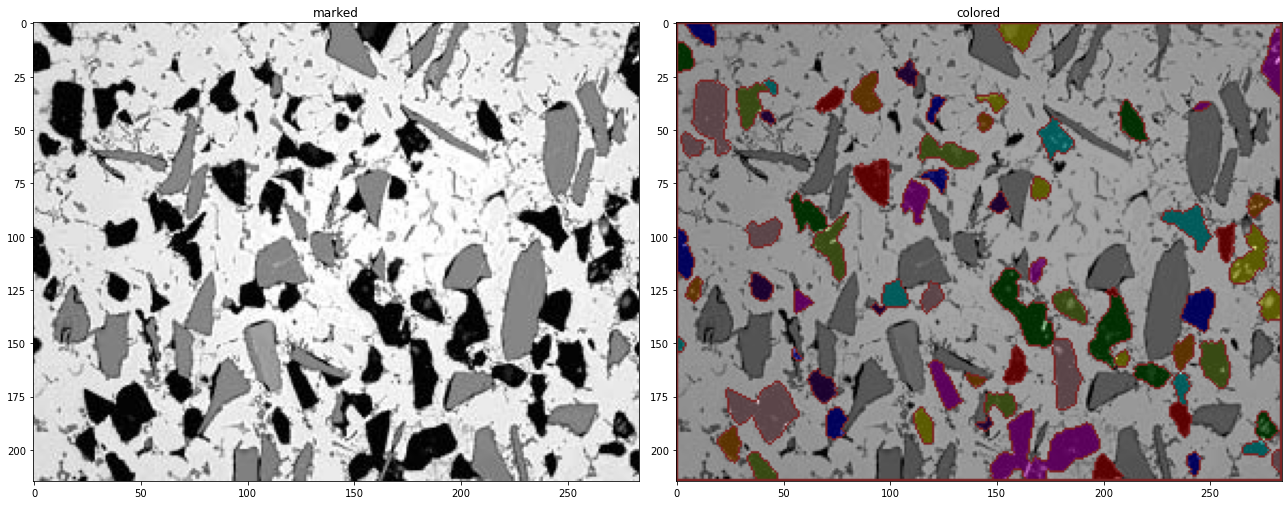

In [12]:
# here are the marked and colorcoded black regions
img_marked2, sure_bg2, sure_fg2, unknown2, markers2, img_colored2 = segment(img,thresh_blur2, 3, 2, 2)

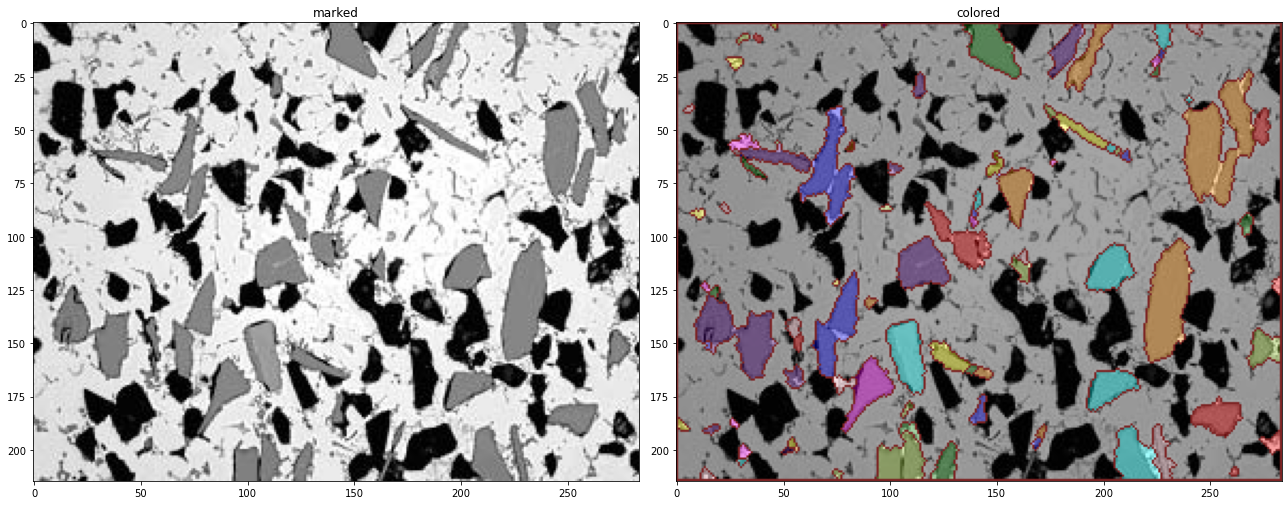

In [13]:
# here are the marked and colorcoded gray regions
img_marked3, sure_bg3, sure_fg3, unknown3, markers3, img_colored3 = segment(img,thresh_blur1-thresh_blur2, 3, 2, 2)

#### Now lets combine our two images to highlight the black and gray regions in one image.  This is not necessary but it makes a nice summary image to see how we did. 

Now recall that in our markers array: 
> (1) The background pixels are marked as 1  
> (2) The boundaries are marked as -1  
> (3) The individual phases are numbered in order from 2 to the number of particles  

In [18]:
# we have two conditions that we want to test for 
# markers2 is the numbered black phases
cond2=markers2>1 #this marks all pixels that have a value greater than 1 to "True" and "False" otherwise
# markers3 is the numbered gray phases
cond3=markers3>1

In [17]:
# Let's make copies of the original image and the two colored images so we don't change these directly
# Note that these images are all RGB colored images
img_original=copy.copy(img)
img_blackphase=copy.copy(img_colored2)
img_grayphase=copy.copy(img_colored3)

In [24]:
# When setting pixel colors here we have to give [Red, Green, Blue]
img_blackphase[cond2]=[0.4,0.1,0.4] # set all black particles to light purple
img_blackphase[~cond2]=[0,0,0] # set all other pixels to black

img_grayphase[cond3]=[0,0.4,0.4] # all gray particles to green-blue
img_grayphase[~cond3]=[0,0,0] # all other pixels to black

# I need to remove the color from all particles in the original image so we can add our colored particles
img_original[cond2|cond3]=[0,0,0] # keep background of original image but convert all black and gray particles to black

# Let's add the two colored images above with the original image 
# the RGB values in the first two images are given as floats from 0 to 1
# the RGB values in img_original are given as integers from 0 to 255 so I need to divide below to convert to 0 to 1
img_combined=img_blackphase+img_grayphase+img_original/255 

Now let's plot our two recolored particles and add them all together with the original image

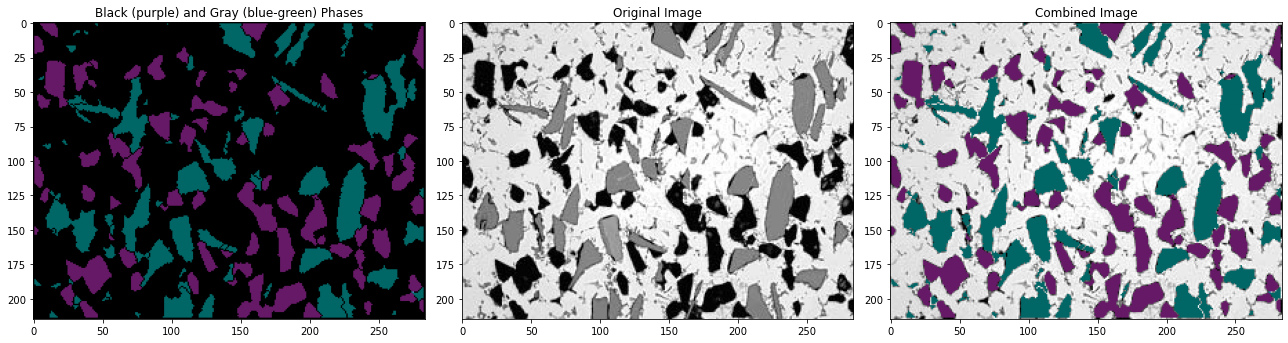

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(18, 18))
ax1.imshow(img_blackphase+img_grayphase)
ax2.imshow(img)
ax3.imshow(img_combined)
ax1.set_title('Black (purple) and Gray (blue-green) Phases')
ax2.set_title('Original Image')
ax3.set_title('Combined Image')
plt.tight_layout()

#### Each colored grain can now be analyzed and placed in a Pandas DataFrame.  We need our original multi-colored files for these. First let's get our $\mu$m per pixel value:   

<IPython.core.display.Javascript object>


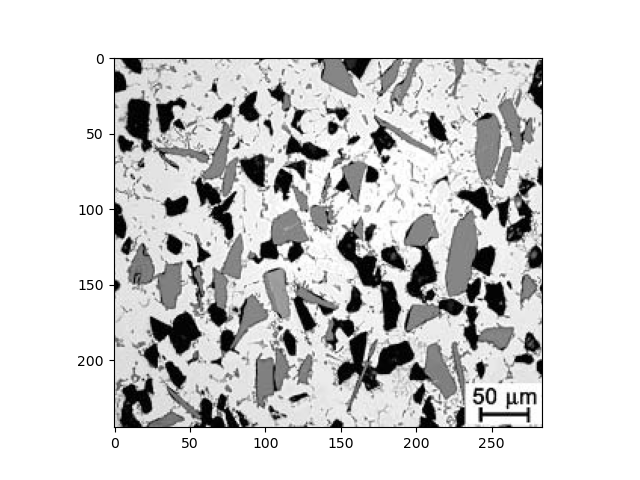

In [30]:
%matplotlib notebook
plt.imshow(imgfull);

In [31]:
%matplotlib inline

> In %matplotlib notebook mode, we can scroll on image to get pixel values.  Here is the start of the 50 micron bar: 
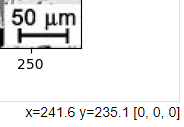
and here is the end of the 50 micron bar: 
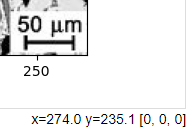
We just need the x pixel values and we use those below:

In [34]:
pixels_to_μm=50/(274.0-241.6)  # 50 μm per (274-241.6) pixels
propList=['label','eccentricity','centroid','area','equivalent_diameter','orientation','major_axis_length', 'minor_axis_length','perimeter']
#propList=['equivalent_diameter','orientation','area','major_axis_length']

props_black=measure.regionprops_table(markers2, properties=propList) # markers2 is for the black pixels
props_gray=measure.regionprops_table(markers3, properties=propList) # markers3 is for the gray pixels

black_data=pd.DataFrame(props_black)
gray_data=pd.DataFrame(props_gray)

In [35]:
black_data.head()  # label=1 is background

label  eccentricity  centroid-0  centroid-1   area  equivalent_diameter  \
0      1      0.655419  103.768453  141.502055  48664           248.919524   
1      2      0.835002    4.548780   12.353659     82            10.217908   
2      4      0.696056    5.171233  160.013699    146            13.634257   
3      5      0.967957   18.613333  279.706667    150            13.819766   
4      6      0.841532   16.250000    3.486111     72             9.574615   

   orientation  major_axis_length  minor_axis_length    perimeter  
0    -1.483001         325.478960         245.822913  4386.675683  
1     0.992072          14.225073           7.827297    36.142136  
2     1.476241          17.110472          12.285113    50.420310  
3    -0.038474          29.760078           7.473212    66.834524  
4     0.120472          13.397863           7.237616    32.485281

Let's print the numeric label for each black grain

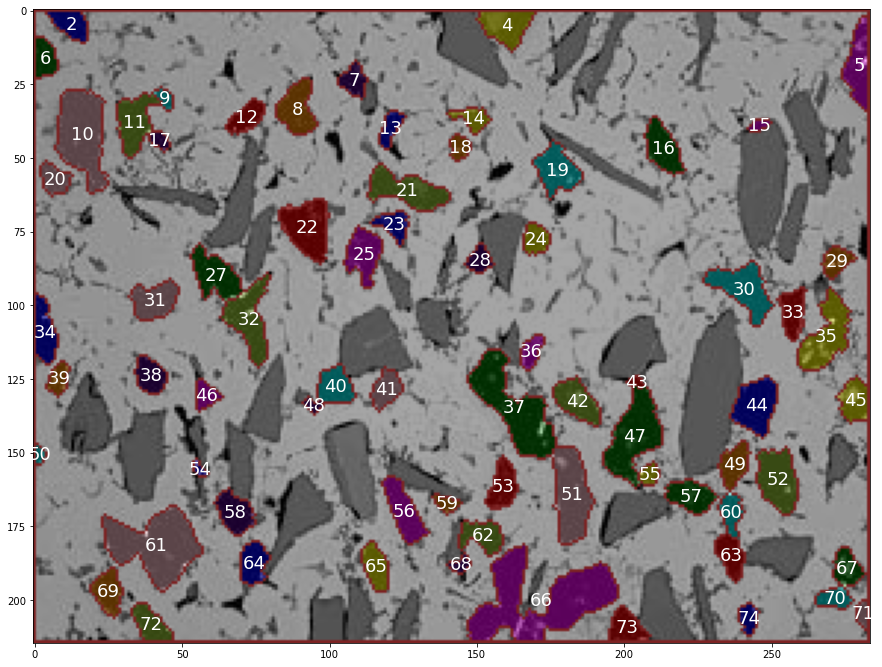

In [38]:
colored_image=img_colored2
data_table=black_data

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(colored_image, aspect='equal');
[ax.annotate(f'{label:0.0f}', xy=(posx, posy), c='white',fontsize=18, horizontalalignment='center', verticalalignment='center') for label, posx, posy in np.array(data_table.loc[1:,['label','centroid-1','centroid-0']])]

plt.show()

In [36]:
gray_data.head() # label = 1 is background

label  eccentricity  centroid-0  centroid-1   area  equivalent_diameter  \
0      1      0.657396  105.084151  139.155742  48009           247.238665   
1      2      0.816497    1.333333   45.666667      3             1.954410   
2      3      0.000000    1.000000   97.000000      1             1.128379   
3      4      0.869379   11.852368  147.693593    359            21.379733   
4      5      0.947692   12.214724  182.263804    163            14.406181   

   orientation  major_axis_length  minor_axis_length    perimeter  
0     1.515886         328.124133         247.256514  4339.149817  
1    -0.785398           2.309401           1.333333     3.414214  
2     0.785398           0.000000           0.000000     0.000000  
3     0.747219          31.416606          15.524390    88.219300  
4    -0.525570          26.744448           8.536455    64.083261

Let's show the labels for the gray particles

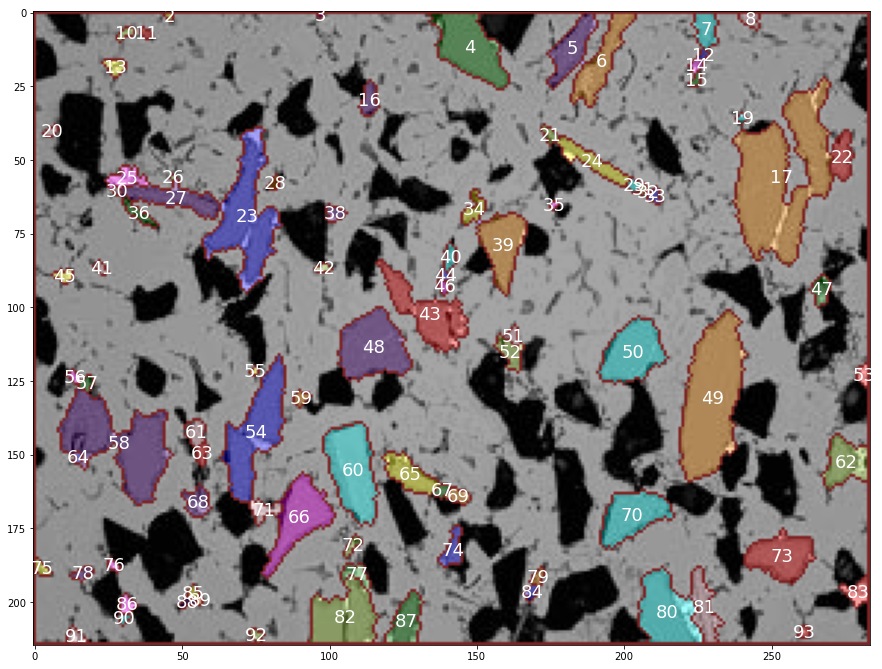

In [39]:
colored_image=img_colored3
data_table=gray_data

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(colored_image, aspect='equal');
[ax.annotate(f'{label:0.0f}', xy=(posx, posy), c='white',fontsize=18, horizontalalignment='center', verticalalignment='center') for label, posx, posy in np.array(data_table.loc[1:,['label','centroid-1','centroid-0']])]

plt.show()

### Let's look at the gray data set and see what type of analysis we can do

In [49]:
# indentifying the data sets to use so I don't have to change the variables in all the code below
grain_data=gray_data
markers=markers3

#### How many particles do we have?

In [45]:
#number of particles
len(grain_data.loc[1:, 'label']) #skipping first row since that is the background. only count particles

89

#### What is the average particle diameter?

In [56]:
temp=(grain_data.loc[1:,'equivalent_diameter']*pixels_to_μm).mean() #table in units of pixels so convert using pixels_to_μm
print(f'average particle diameter = {temp:0.1f} μm')

average particle diameter = 13.0 μm


#### What is the average area of a gray particle?

In [58]:
temp=(grain_data.loc[1:,'area']*pixels_to_μm**2).mean() #don't forget to square pixel to μm conversion since we are looking at an area
print(f'average particle area = {temp:0.1f} μm^2')

average particle area = 247.1 μm^2


#### What is the area percent of particles in the image?

In [53]:
interface_pix=len(markers[markers==-1]) #interface pixels are labeled -1
#let's assign half of the interface pixels to the background and half to the particles
background_pix=len(markers[markers==1])+interface_pix/2 #background pixels are labeled 1
particles_pix=len(markers[markers>1])+interface_pix/2 #particle pixels are all numbers greater than 1
total_pix=background_pix+particles_pix

print(f'Percentage of gray phase is: {particles_pix/total_pix*100:0.1f} %')

Percentage of gray phase is: 18.2 %


### How about some histograms of properties

#### Histogram of particle orientations.  Measures angle from the vertical for the long axis of a given particle.  Useful for seeing any orientation preference in the material.  

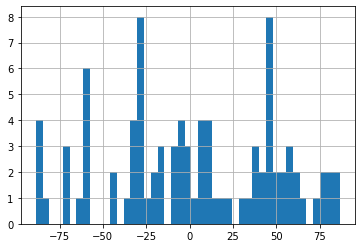

In [81]:
(grain_data['orientation']*180/np.pi).hist(bins=45); # these angles are measured relative to the vertical

#### Histogram of particle eccentricity.  A value of zero corresponds to a circle.  

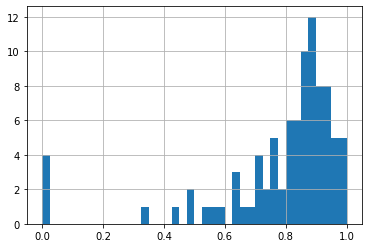

In [62]:
# when eccentricity = 0 the ellipse becomes a circle
grain_data.loc[1:, 'eccentricity'].hist(bins=40);

#### Histogram of particle diameters.  Let's use matplotlib's histogram for more control. 

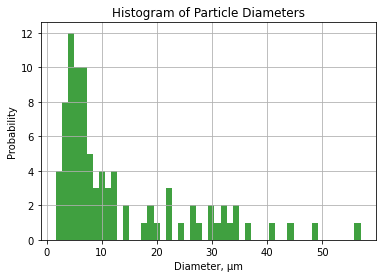

In [74]:
n, bins, patches = plt.hist((grain_data.loc[1:, 'equivalent_diameter']*pixels_to_μm), bins=50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Diameter, μm')
plt.ylabel('Probability')
plt.title('Histogram of Particle Diameters')
#plt.xlim(0, 60)
#plt.ylim(0, 0.15)
plt.grid(True)
plt.show()

## Now this could be repeated for the black particles using black_data and markers2

In [ ]:
# grain_data=black_data
# markers=markers2